In [ ]:
!pip install kaggle

In [ ]:
!pip install retina-face

In [ ]:
!pip3 install wandb

In [4]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [5]:
!kaggle datasets download -d ashishjangra27/gender-recognition-200k-images-celeba

 99% 1.31G/1.32G [00:26<00:00, 57.1MB/s]
100% 1.32G/1.32G [00:26<00:00, 53.1MB/s]


In [6]:
!unzip -qq gender-recognition-200k-images-celeba.zip

In [19]:
import wandb
import numpy as np
import cv2
import tensorflow as tf
from retinaface import RetinaFace
from wandb.keras import WandbCallback
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot as plt
from tensorflow.keras.layers import Dense, MaxPool2D, Conv2D, Flatten, BatchNormalization, MaxPooling2D, Dropout
from tensorflow.keras.optimizers import SGD, Adam
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
wandb.init(project='gender-recognition')

In [9]:
batch_size = 256
lr = 0.001
epoch = 40
width = height = 64

In [10]:
data_generator = ImageDataGenerator(
                                  rescale = 1 / 255,
                                  horizontal_flip = True
                                  )

train_data = data_generator.flow_from_directory("Dataset/Train/",
                                                    target_size = (width, height),
                                                    class_mode = 'categorical',
                                                    batch_size = batch_size,
                                                    shuffle = True
                                                    )

val_data = data_generator.flow_from_directory("Dataset/Validation/",
                                                    target_size = (width, height),
                                                    class_mode = 'categorical',
                                                    batch_size = batch_size,
                                                    shuffle = True
                                                    )

test_data = data_generator.flow_from_directory("Dataset/Test/",
                                                    target_size = (width, height),
                                                    class_mode = 'categorical',
                                                    batch_size = batch_size,
                                                    shuffle = False
                                                    )

Found 160000 images belonging to 2 classes.
Found 22598 images belonging to 2 classes.
Found 20001 images belonging to 2 classes.


In [13]:
model = tf.keras.models.Sequential([

    Conv2D(96, (11, 11), activation= 'relu', input_shape = (width, height, 3)),
    BatchNormalization(),
    MaxPooling2D(2),


    Conv2D(256, (11, 11), strides=(1, 1), activation= 'relu', padding= 'same'),
    BatchNormalization(),


    Conv2D(384, (3, 3), strides=(1, 1), activation= 'relu', padding= 'same'),
    BatchNormalization(),


    Conv2D(384, (3, 3), strides=(1, 1), activation= 'relu', padding= 'same'),
    BatchNormalization(),


    Conv2D(256, (3, 3), strides=(1, 1), activation= 'relu', padding= 'same'),
    BatchNormalization(),
    MaxPooling2D(2, strides= (2, 2)),


    Flatten(),


    Dense(4096, activation= 'relu'),
    Dropout(0.5),


    Dense(4096, activation= 'relu'),
    Dropout(0.5),


    Dense(2, activation='sigmoid')                          
])

In [ ]:
base_model = tf.keras.applications.ResNet50V2(
    input_shape=(width, height, 3),
    include_top = False,
    weights = 'imagenet',
    pooling = 'max'
    )

94683136/94668760 [==============================] - 2s 0us/step


In [ ]:
for layer in base_model.layers[:-8]:
  layer.trainable = False

In [ ]:
model = tf.keras.models.Sequential([
    base_model,
    Dense(2, activation='softmax')                          
])

In [14]:
model.compile(optimizer = tf.keras.optimizers.SGD(),
              loss = tf.keras.losses.categorical_crossentropy,
              metrics='accuracy')

In [15]:
model.fit(train_data,
          steps_per_epoch = train_data.samples / batch_size,
          validation_data = val_data,
          validation_steps = val_data.samples / batch_size,
          epochs = 3,
          callbacks = [WandbCallback()]
)

Epoch 1/3
625/625 [==============================] - 875s 1s/step - loss: 0.4449 - accuracy: 0.8308 - val_loss: 0.1987 - val_accuracy: 0.9223
Epoch 2/3
625/625 [==============================] - 813s 1s/step - loss: 0.1587 - accuracy: 0.9356 - val_loss: 0.1223 - val_accuracy: 0.9517
Epoch 3/3
625/625 [==============================] - 807s 1s/step - loss: 0.1250 - accuracy: 0.9503 - val_loss: 0.1218 - val_accuracy: 0.9527


In [16]:
model.save('/content/drive/MyDrive/gender_model_resnet.h5')

In [17]:
Y_pred = model.predict(test_data)
y_pred = np.argmax(Y_pred, axis= 1)

print(confusion_matrix(test_data.classes, y_pred))
targets = set(test_data.class_indices.keys())
print('classification_report:')
print(classification_report(test_data.classes, y_pred, target_names= targets))

[[11275   267]
 [  535  7924]]
classification_report:
              precision    recall  f1-score   support

      Female       0.95      0.98      0.97     11542
        Male       0.97      0.94      0.95      8459

    accuracy                           0.96     20001
   macro avg       0.96      0.96      0.96     20001
weighted avg       0.96      0.96      0.96     20001



In [20]:
def process_and_predict(image_path):
    faces = RetinaFace.extract_faces(img_path= image_path, align= True)
    image = faces[0]
    image = cv2.resize(image, (width, height))
    plt.imshow(image)
    image = image / 255.0
    image = np.expand_dims(image, axis= 0)
    res = np.argmax(model.predict(image))
    if res == 0:
        print('Female\n')
    else:
        print('Male\n')

Male



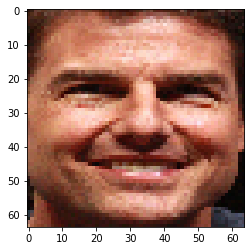

In [23]:
process_and_predict('Tom.jpeg')

Female



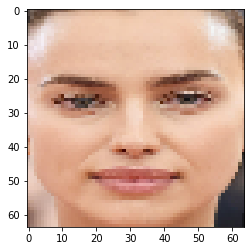

In [22]:
process_and_predict('sh.jpeg')